In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [2]:
warnings.filterwarnings('ignore')
np.random.seed(42)

data_path = "/kaggle/input/nlp-stock-data/indo_raw_with_emoji.csv"
label_encoder = LabelEncoder()

# Data Preparation

In [3]:
df = pd.read_csv(data_path)
df.dropna(subset=['Processed_Sentence', 'Sentiment'], inplace=True)

X = df['Processed_Sentence'].tolist()
y = label_encoder.fit_transform(df['Sentiment'])
NUM_LABELS = len(label_encoder.classes_)

print("Label mapping:", {i: label for i, label in enumerate(label_encoder.classes_)})

Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Data split - Train: 2301, Val: 493, Test: 494


# TF-IDF Vectorizer

In [5]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Model

In [6]:
def train_and_evaluate_model(model, model_name, X_train_vec, y_train, X_val_vec, y_val):
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train_vec, y_train)
    y_pred_val = model.predict(X_val_vec)
    accuracy = accuracy_score(y_val, y_pred_val)
    f1_macro = f1_score(y_val, y_pred_val, average='macro')

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1 Macro: {f1_macro:.4f}")
    print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_, digits=4))

    return model

In [7]:
rf_model = train_and_evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42),
    "Random Forest",
    X_train_tfidf, y_train,
    X_val_tfidf, y_val
)

nb_model = train_and_evaluate_model(
    MultinomialNB(),
    "Naive Bayes",
    X_train_tfidf, y_train,
    X_val_tfidf, y_val
)

svm_model = train_and_evaluate_model(
    SVC(kernel='linear', random_state=42),
    "Linear SVM",
    X_train_tfidf, y_train,
    X_val_tfidf, y_val
)


--- Training Random Forest ---
Validation Accuracy: 0.7302
Validation F1 Macro: 0.6611
              precision    recall  f1-score   support

    Negative     0.6952    0.6186    0.6547       118
     Neutral     0.8889    0.3636    0.5161       110
    Positive     0.7201    0.9321    0.8125       265

    accuracy                         0.7302       493
   macro avg     0.7681    0.6381    0.6611       493
weighted avg     0.7518    0.7302    0.7086       493


--- Training Naive Bayes ---
Validation Accuracy: 0.6897
Validation F1 Macro: 0.5802
              precision    recall  f1-score   support

    Negative     0.8088    0.4661    0.5914       118
     Neutral     0.9259    0.2273    0.3650       110
    Positive     0.6533    0.9811    0.7843       265

    accuracy                         0.6897       493
   macro avg     0.7960    0.5582    0.5802       493
weighted avg     0.7513    0.6897    0.6446       493


--- Training Linear SVM ---
Validation Accuracy: 0.7688
Validat

# Evaluation

In [8]:
def evaluate_on_test(model, model_name, X_test_vec, y_test):
    y_pred_test = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"\n--- {model_name} Test Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_, digits=4))
    return y_pred_test

In [9]:
rf_test_preds = evaluate_on_test(rf_model, "Random Forest", X_test_tfidf, y_test)
nb_test_preds = evaluate_on_test(nb_model, "Naive Bayes", X_test_tfidf, y_test)
svm_test_preds = evaluate_on_test(svm_model, "Linear SVM", X_test_tfidf, y_test)


--- Random Forest Test Results ---
Accuracy: 0.7206
              precision    recall  f1-score   support

    Negative     0.7292    0.5932    0.6542       118
     Neutral     0.9048    0.3455    0.5000       110
    Positive     0.6966    0.9323    0.7974       266

    accuracy                         0.7206       494
   macro avg     0.7769    0.6237    0.6505       494
weighted avg     0.7507    0.7206    0.6970       494


--- Naive Bayes Test Results ---
Accuracy: 0.6842
              precision    recall  f1-score   support

    Negative     0.7941    0.4576    0.5806       118
     Neutral     0.8966    0.2364    0.3741       110
    Positive     0.6499    0.9699    0.7783       266

    accuracy                         0.6842       494
   macro avg     0.7802    0.5546    0.5777       494
weighted avg     0.7393    0.6842    0.6411       494


--- Linear SVM Test Results ---
Accuracy: 0.7773
              precision    recall  f1-score   support

    Negative     0.7642    0.

## Evaluating Best Model (SVM)

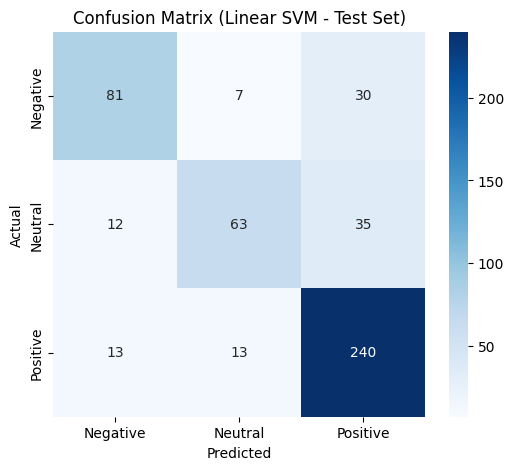

In [10]:
cm = confusion_matrix(y_test, svm_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Linear SVM - Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
wrong_pred_indices = np.where(y_test != svm_test_preds)[0]
wrong_predictions_df = pd.DataFrame({
    'Sentence': [X_test[i] for i in wrong_pred_indices],
    'Actual Sentiment': label_encoder.inverse_transform(y_test[wrong_pred_indices]),
    'Predicted Sentiment': label_encoder.inverse_transform(svm_test_preds[wrong_pred_indices])
})

wrong_predictions_df.to_csv('wrong_predictions_SVM.csv', index=False)

display(wrong_predictions_df.head())

,Sentence,Actual Sentiment,Predicted Sentiment
0,Bmri mumpung lg koreksi,Positive,Negative
1,pak buat sekuritas mirae apakah bisa pakai aku...,Neutral,Positive
2,Ancaman Delisting Saham BYAN dan HMSP dari BEI...,Negative,Neutral
3,"Ajaib Sekuritas: IHSG Mixed, Cermati Saham Pil...",Neutral,Positive
4,"Hari ini cum dividen ASRM (Rp 65), BIRD (Rp 72...",Neutral,Positive
